# Project 2: Voiced (유성음), Unvoiced (무성음), Silence (묵음)을 구분하는 분류기 생성
## 경북대학교 대학원 전자전기공학부 오지현
### 모든 모음은 유성음, 자음중 /s/, /f/, /th/, /ch/, /k/, /p/, /t/ 은 무성음

# Package 호출

In [2]:
import os
import sys
import numpy as np
import natsort
import glob
import random
import librosa
from distutils.dir_util import copy_tree
import re
import nltk
from nltk.corpus import cmudict
import IPython # display wav files
from collections import Counter
import scipy.io.wavfile as wav
from scipy.signal import medfilt
import scipy.signal as sps
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from gjdrawspectrogram3 import drawspectrogram3 # draw spectrogram
from gjfiroverlapadd import getLPHFIRFFT # linear phase FIR filter design from magnitudes of the frequency components
from gjfiroverlapadd import firoverlapadd # trapezoidal overlap add for FIR filtering
import gjwavfile as gwav # save audio in wav format
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

#### 필요한 값 정의

In [3]:
Fs = 16000
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의

cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
FIG_SIZE = (8,3)

In [4]:
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file


def split_folder(src_folder, train_folder, val_folder, train_ratio=0.8, random_seed=42):
    # 폴더 내 파일 목록 가져오기
    files = os.listdir(src_folder)
    num_files = len(files)
    
    # 파일 목록을 랜덤하게 섞기
    random.seed(random_seed)
    random.shuffle(files)
    
    # train 및 validation 파일 개수 계산
    num_train = int(num_files * train_ratio)
    num_valid = num_files - num_train
    
    # train 파일 복사
    for i in range(num_train):
        file_name = files[i]
        src_path = addpath(src_folder, file_name)
        dst_path = addpath(train_folder, file_name)
        copy_tree(src_path, dst_path)
        
    # validation 파일 복사
    for i in range(num_train, num_files):
        file_name = files[i]
        src_path = addpath(src_folder, file_name)
        dst_path = addpath(val_folder, file_name)
        copy_tree(src_path, dst_path)
        
def split_wav(data, sample_rate, start, end):
    start *= sample_rate
    end *= sample_rate
    return data[start:end]

def DeleteAllFiles(filePath):
    if os.path.exists(filePath):
        for file in os.scandir(filePath):
            os.remove(file.path)
        os.rmdir(filePath)
        return 'Remove All File'
    else:
        return 'Directory Not Found'
    
def remove_files_in_directory(directory):
    file_list = os.listdir(directory)
    for file_name in file_list:
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)

silence_duration_start = 0.5  # 앞에 추가할 무음의 지속 시간 (초)
silence_duration_end = 0.5  # 뒤에 추가할 무음의 지속 시간 (초)

def name_extract(file):
    # 디렉토리 추출
    directory = os.path.dirname(file)

    # 파일 이름과 확장자 분리
    filename, extension = os.path.splitext(file)

    # "sa" 뒤의 단어 추출
    sa_word = os.path.basename(directory).split('_')[1]

    # ".wav" 앞의 단어 추출
    wav_word = filename.split('/')[-1].split('_')[-1]
    
    return sa_word, wav_word

            
def plot_figure(file, sound, fs):
    
    sa_word, wav_word = name_extract(file)
    
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
    plt.subplots_adjust(wspace=0.4, hspace=0.35)
    plt.subplot(1,2,1)
    plt.plot(sound); plt.xlim(0+silence_duration_start*10000,len(sound)-silence_duration_end*10000); plt.ylim(-0.02,0.025); plt.xticks([0+silence_duration_start*10000, len(sound)-silence_duration_end*10000])
    plt.title(sa_word + " '" + wav_word + "'")
    plt.subplot(1,2,2)
    drawspectrogram3(sound, fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)

def find_most_common_word(word_list):
    word_count = Counter(word_list)
    most_common_word = word_count.most_common(1)[0][0]
    return most_common_word

# Train / Validation / Test
## 1. timit/train 데이터 8:2로 나누기 (Train:8, Validation: 2)
## 2. SA(dialect sentences)로 train / validation / test
## 3. SX(phonetically compact)로 train / validation / test

## 1. timit/train 데이터 8:2로 나누기 (Train:8, Validation: 2)

In [5]:
file_dir = 'timit_wav'
train_dir = addpath(file_dir,'train')            # 원래 train 파일 디렉토리
new_train_dir = addpath(file_dir, 'train_new')   # 분류한 train 파일 디렉토리
val_dir = addpath(file_dir, 'val')               # 분류한 validation 파일 디렉토리

if not os.path.exists(new_train_dir):
    os.makedirs(new_train_dir)
    
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

train_file_list = os.listdir(train_dir)
train_file_count = len(train_file_list)

for i in range(train_file_count):
    basename = 'dr%d'%(i+1)
    sub_train_dir = addpath(train_dir, basename)         # train 파일의 하위 디렉토리 dialect region ex: timit_wav/train/dr1
    newsub_train_dir = addpath(new_train_dir, basename)  # 분류 train 파일의 하위 디렉토리 ex: timit_wav/train_new/dr1
    sub_val_dir = addpath(val_dir, basename)             # validation 파일의 하위 디렉토리
    if not os.path.exists(newsub_train_dir):
        os.makedirs(newsub_train_dir)
    if not os.path.exists(sub_val_dir):
        os.makedirs(sub_val_dir)
        
    split_folder(sub_train_dir, newsub_train_dir, sub_val_dir, train_ratio=0.8, random_seed=42)

## 2. SA(dialect sentences)로 train / validation / test
### 2-1. EPD or VAD 를 이용하여 1차 구분
### 2-2. autocorrelation 을 이용하여 voiced/unvoiced rough 구분
### 2-3. ZCR, median filter, heuristic 적용
### 2-4. RNN

#### 관련 함수

In [52]:
nltk.data.path.append("/Volumes/OGSSD/OG/__Me__/KNU/대학원/수업/2023/음성신호처리실습/ssp2023-main/proj2")

In [61]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import nltk
nltk.download('punkt')
nltk.download('cmudict')

[nltk_data] Downloading package punkt to /Users/ojihyeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package cmudict to
[nltk_data]     /Users/ojihyeon/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


True

In [6]:
# EPD 음성구간 확장 함수 ---------------------------------------------------------------------------------------
def add_silence_to_wav(data, sample_rate, silence_duration_start, silence_duration_end):
    # 무음을 위한 샘플 개수 계산
    num_samples_start = int(silence_duration_start * sample_rate)
    num_samples_end = int(silence_duration_end * sample_rate)

    # 무음 샘플 생성
    if data.ndim == 1:
        # 단일 채널 WAV 파일인 경우
        silence_start = np.zeros(num_samples_start, dtype=data.dtype)
        silence_end = np.zeros(num_samples_end, dtype=data.dtype)
    else:
        # 다중 채널 WAV 파일인 경우
        num_channels = data.shape[1]
        silence_start = np.zeros((num_samples_start, num_channels), dtype=data.dtype)
        silence_end = np.zeros((num_samples_end, num_channels), dtype=data.dtype)

    # 무음을 WAV 데이터 앞뒤에 추가
    data_with_silence = np.concatenate((silence_start, data, silence_end))

    return data_with_silence


def epd(wrd_file, phn_file, wav_dir, cnt):
    
    silence_duration_start = 0.5  # 앞에 추가할 무음의 지속 시간 (초)
    silence_duration_end = 0.5  # 뒤에 추가할 무음의 지속 시간 (초)

    wrd_file = open(wrd_file, 'r')
    phn_file = open(phn_file, 'r')
    wrd_data = wrd_file.readlines()
    phn_data = phn_file.readlines()

    sr, y = wav.read(addpath(wav_dir, 'sa{}.wav'.format(cnt+1)))

    # .wrd 파일에 대하여 EPD 음성 확장
    for q in range(len(wrd_data)):
        wrd_num_line = re.findall("\d+", wrd_data[q])  # print(wrd_num_line)
        wrd_str_line = re.findall(r'[^\d\s]+', wrd_data[q]) # print(wrd_str_line) #print(num_line[0], num_line[1]) #print(str_line[0])
        output_wrd_wav_file = addpath(addpath(wav_dir, 'sa_words'), 'sa{}_{}_{}.wav'.format(cnt+1,q+1,wrd_str_line[0]))  
        wrd_y_seg = y[int(wrd_num_line[0]):int(wrd_num_line[1])]

        # 무음 추가
        wrd_data_with_silence = add_silence_to_wav(wrd_y_seg, sr, silence_duration_start, silence_duration_end)

        wav.write(output_wrd_wav_file, sr, wrd_data_with_silence)

     # .phn 파일에 대하여 EPD 음성 확장
    for r in range(len(phn_data)):
        phn_num_line = re.findall("\d+", phn_data[r])  # print(phn_num_line)
        phn_str_line = re.findall(r'[^\d\s]+', phn_data[r]) # print(phn_str_line) #print(phn_num_line[0], phn_num_line[1]) #print(phn_str_line[0])
        output_phn_wav_file = addpath(addpath(wav_dir, 'sa_sounds'), 'sa{}_{}_{}.wav'.format(cnt+1,r+1,phn_str_line[0]))  
        phn_y_seg = y[int(phn_num_line[0]):int(phn_num_line[1])]

        # 무음 추가
        phn_data_with_silence = add_silence_to_wav(phn_y_seg, sr, silence_duration_start, silence_duration_end)

        wav.write(output_phn_wav_file, sr, phn_data_with_silence)

    wrd_file.close()
    phn_file.close()
    
def epd2(wrd_file, phn_file, wav_dir, cnt):
    
    silence_duration_start = 0.5  # 앞에 추가할 무음의 지속 시간 (초)
    silence_duration_end = 0.5  # 뒤에 추가할 무음의 지속 시간 (초)

    wrd_file = open(wrd_file, 'r')
    phn_file = open(phn_file, 'r')
    wrd_data = wrd_file.readlines()
    phn_data = phn_file.readlines()

    sr, y = wav.read(addpath(wav_dir, 'sx{}.wav'.format(cnt)))

    # .wrd 파일에 대하여 EPD 음성 확장
    for q in range(len(wrd_data)):
        wrd_num_line = re.findall("\d+", wrd_data[q])  # print(wrd_num_line)
        wrd_str_line = re.findall(r'[^\d\s]+', wrd_data[q]) # print(wrd_str_line) #print(num_line[0], num_line[1]) #print(str_line[0])
        output_wrd_wav_file = addpath(addpath(wav_dir, 'sx_words'), 'sx{}_{}_{}.wav'.format(cnt,q+1,wrd_str_line[0]))  
        wrd_y_seg = y[int(wrd_num_line[0]):int(wrd_num_line[1])]

        # 무음 추가
        wrd_data_with_silence = add_silence_to_wav(wrd_y_seg, sr, silence_duration_start, silence_duration_end)

        wav.write(output_wrd_wav_file, sr, wrd_data_with_silence)

     # .phn 파일에 대하여 EPD 음성 확장
    for r in range(len(phn_data)):
        phn_num_line = re.findall("\d+", phn_data[r])  # print(phn_num_line)
        phn_str_line = re.findall(r'[^\d\s]+', phn_data[r]) # print(phn_str_line) #print(phn_num_line[0], phn_num_line[1]) #print(phn_str_line[0])
        output_phn_wav_file = addpath(addpath(wav_dir, 'sx_sounds'), 'sx{}_{}_{}.wav'.format(cnt,r+1,phn_str_line[0]))  
        phn_y_seg = y[int(phn_num_line[0]):int(phn_num_line[1])]

        # 무음 추가
        phn_data_with_silence = add_silence_to_wav(phn_y_seg, sr, silence_duration_start, silence_duration_end)

        wav.write(output_phn_wav_file, sr, phn_data_with_silence)

    wrd_file.close()
    phn_file.close()
    
def compute_spectrogram(waveform, sample_rate):
    spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)
    log_mel_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_mel_spectrogram
    

def load_data(file_path):
    features = []
    labels = []
    max_len = 0  # 가장 긴 시퀀스의 길이
    
    for file in file_path:
        audio, sr = librosa.load(file, sr=None)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # sr 값을 명시적으로 전달
        features.append(mfcc.T)  # 전치하여 시퀀스를 [시간, 특성] 형태로 변환
        sa_word, wav_word = name_extract(file)
        label_sequence = convert_arpabet_to_label(wav_word)
        labels.append(label_sequence)
        
        # 최대 길이 갱신
        max_len = max(max_len, len(label_sequence))
    
    scaler = StandardScaler()
    features_scaled = [scaler.fit_transform(f) for f in features]  # 특성 스케일링
    
    features_padded = pad_sequences(features_scaled, maxlen=max_len, dtype=np.float32, padding='post', truncating='post')  # 패딩 적용
    labels = np.array(labels)
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels.reshape(-1))  # 레이블 값을 정수로 변환 (reshape(-1) 사용)
    
    #labels = to_categorical(labels)
    
    return features_padded, labels, label_encoder

# Arpabet과 레이블 대응 관계 정의
arpabet_to_label = {
    'aa': 'voiced',
    'ae': 'voiced',
    'ah': 'voiced',
    'ao': 'voiced',
    'aw': 'voiced',
    'ay': 'voiced',
    'b': 'voiced',
    'ch': 'voiced',
    'd': 'voiced',
    'dcl': 'voiced',#
    'dh': 'voiced',
    'dx': 'voiced', #
    'eh': 'voiced',
    'epi': 'voiced', #
    'er': 'voiced',
    'ey': 'voiced',
    'f': 'voiced',
    'g': 'voiced',
    'gcl': 'voiced',
    'hh': 'unvoiced',
    'hv': 'voiced', #
    'ih': 'voiced',
    'ix': 'voiced',
    'iy': 'voiced',
    'jh': 'voiced',
    'k': 'unvoiced',
    'kcl': 'voiced',#
    'l': 'voiced',
    'm': 'voiced',
    'n': 'voiced',
    'ng': 'voiced',
    'ow': 'voiced',
    'oy': 'voiced',
    'p': 'unvoiced',
    'q': 'voiced',
    'r': 'voiced',
    's': 'unvoiced',
    'sh': 'unvoiced',
    't': 'unvoiced',
    'tcl': 'voiced',
    'th': 'unvoiced',
    'uh': 'voiced',
    'uw': 'voiced',
    'v': 'voiced',
    'w': 'voiced',
    'y': 'voiced',
    'z': 'voiced',
    'zh': 'voiced',
    'sil': 'silence'
}

# Arpabet 표기를 레이블로 변환하는 함수
def convert_arpabet_to_label(arpabet_sequence):
    arpabet_lower = arpabet_sequence.lower()
    label = [arpabet_to_label.get(phoneme, 'silence') for phoneme in arpabet_lower.split()]
    return label

# CMU Pronouncing Dictionary 로드
arpabet = cmudict.dict()

def get_arpabet(word):
    # 소문자로 변환
    word = word.lower()

    # CMU Pronouncing Dictionary에서 ARPABET 표기를 가져옴
    if word in arpabet:
        return arpabet[word][0]
    else:
        return None
    
# Autocorrelation을 통한 voiced/unvoiced 구분 함수 ------------------------------------------------------------
def classify_voiced_unvoiced(audio):
    # Autocorrelation 계산
    autocorr = np.correlate(audio, audio, mode='full')
    autocorr = autocorr[len(autocorr) // 2:]
    #max_autocorr = np.max(autocorr)

    ratio = autocorr[1] / autocorr[0] #print("ratio", ratio)
    #ratio = max_autocorr / autocorr[0]

    # Threshold 값 설정
    voiced_threshold = 0.72
    unvoiced_threshold = 0.2

    if ratio > voiced_threshold:
        return 'voiced'
    elif ratio < unvoiced_threshold:
        return 'unvoiced'
    else:
        return 'silence'

# ZCR(Zero-Crossing Rate), Median Filter, Heuristic 적용 함수 ----------------------------------------------------------------------------
def calculate_zcr(signal):
    # Zero Crossing Rate(ZCR) 계산
    if len(signal) == 0:
        return 0.0
    zcr = np.mean(np.abs(np.diff(np.sign(signal))))
    return zcr

def classify_voiced_unvoiced_silence(audio):
    # ZCR 계산
    zcr = calculate_zcr(audio)

    # Median filter 적용
    if len(audio) > 0:
        median_filtered = medfilt(audio, kernel_size=5)
    else:
        median_filtered = np.array([])
    #print(median_filtered)
    
    # Median Filter 이후의 ZCR 계산
    zcr_filtered = calculate_zcr(median_filtered) #print(zcr_filtered)
    

# Heuristic 기반 분류
    voiced_threshold = 0.03
    unvoiced_threshold = 0.09
    
    if zcr_filtered < voiced_threshold:
        return 'voiced'
    elif voiced_threshold < zcr_filtered < unvoiced_threshold :
        return 'unvoiced'
    else:
        return 'silence'

#### 2-1. EPD or VAD 를 이용하여 1차 구분

train data EPD

In [7]:
new_train_list = os.listdir(new_train_dir)  # ['dr1', 'dr2', 'dr3', 'dr4', 'dr5', 'dr6', 'dr7', 'dr8']

for i in new_train_list:
    sub_train_dir = addpath(new_train_dir, i)  # timit_wav/train_new/dr*
    new_sub_train_list = os.listdir(sub_train_dir) # dr의 하위 디렉토리
    new_sub_train_list = natsort.natsorted(new_sub_train_list) # 제대로 불러왔는지 확인하기 위해 sort
    
    # SA wav file 경로 호출
    for j in new_sub_train_list:
        wav_dir = addpath(sub_train_dir, j) # timit_wav/train_new/dr1/fcjf0
        sa_wav_file = glob.glob(f"{wav_dir}/sa*.wav")
        sa_wrd_file = glob.glob(f"{wav_dir}/sa*.wrd")
        sa_phn_file = glob.glob(f"{wav_dir}/sa*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sa_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_words'))
        if not os.path.exists(addpath(wav_dir, 'sa_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_sounds'))
        
        for p in range(len(sa_wrd_file)):
            epd(sa_wrd_file[p], sa_phn_file[p], wav_dir, p)

        #remove_files_in_directory(wav_dir)

validation data EPD

In [8]:
val_list = os.listdir(val_dir) # ['dr1', 'dr2', 'dr3', 'dr4', 'dr5', 'dr6', 'dr7', 'dr8']

for i in val_list:
    sub_val_dir = addpath(val_dir, i)
    sub_val_list = os.listdir(sub_val_dir)
    sub_val_list = natsort.natsorted(sub_val_list)
    
    # SA wav file 경로 호출
    for j in sub_val_list:
        wav_dir = addpath(sub_val_dir, j) # timit_wav/train_new/dr1/fcjf0
        sa_wav_file = glob.glob(f"{wav_dir}/sa*.wav")
        sa_wrd_file = glob.glob(f"{wav_dir}/sa*.wrd")
        sa_phn_file = glob.glob(f"{wav_dir}/sa*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sa_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_words'))
        if not os.path.exists(addpath(wav_dir, 'sa_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_sounds'))
        
        for p in range(len(sa_wrd_file)):
            epd(sa_wrd_file[p], sa_phn_file[p], wav_dir, p)

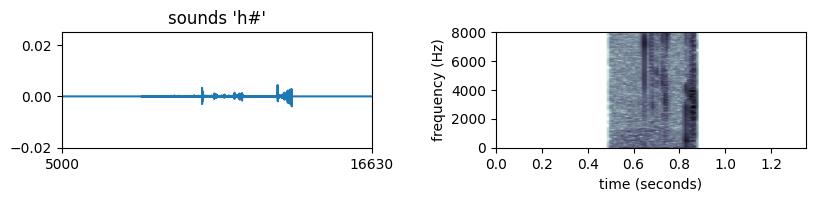

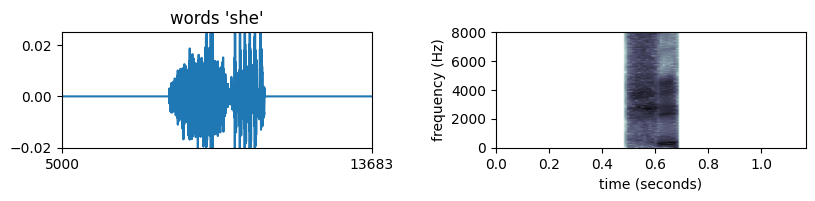

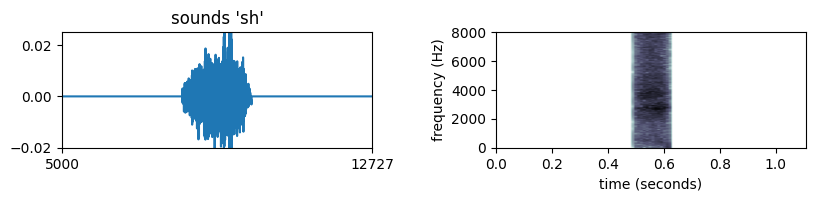

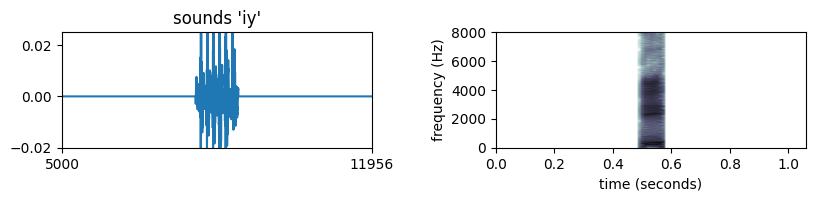

In [9]:
# autocorrelation 전 original signal plot
file = addpath(wav_dir, 'sa_sounds/sa1_1_h#.wav')
word_wav_file = addpath(wav_dir, 'sa_words/sa1_1_she.wav')
phoneme_wav_file_1 = addpath(wav_dir, 'sa_sounds/sa1_2_sh.wav')
phoneme_wav_file_2 = addpath(wav_dir, 'sa_sounds/sa1_3_iy.wav')
speech, Fs = librosa.load(file, sr=None, mono=True)
speech1, Fs1 = librosa.load(word_wav_file, sr=None, mono=True)
speech2, Fs2 = librosa.load(phoneme_wav_file_1, sr=None, mono=True)
speech3, Fs3 = librosa.load(phoneme_wav_file_2, sr=None, mono=True)

plot_figure(file, speech, Fs)
plot_figure(word_wav_file, speech1, Fs1)
plot_figure(phoneme_wav_file_1, speech2, Fs2)
plot_figure(phoneme_wav_file_2, speech3, Fs3)

train data

In [10]:
train_files = []

for i in new_train_list:
    sub_train_dir = addpath(new_train_dir, i)  # timit_wav/train_new/dr*
    ssub_train_list = os.listdir(sub_train_dir)
    ssub_train_list = natsort.natsorted(ssub_train_list)
    
    # .phn 파일 호출
    for j in ssub_train_list:
        sx_sounds_train_dir = addpath(addpath(sub_train_dir, j), 'sa_sounds') # timit_wav/train_new/dr*/*/sa_sounds
        train_file = glob.glob(addpath(sx_sounds_train_dir, '*.wav'))
        train_files.extend(train_file)

validation data

In [11]:
val_files = []
for i in val_list:
    sub_val_dir = addpath(val_dir, i)
    sub_val_list = os.listdir(sub_val_dir)
    sub_val_list = natsort.natsorted(sub_val_list)
    
    # .phn 파일 호출
    for j in sub_val_list:
        sx_sounds_val_dir = addpath(addpath(sub_val_dir, j), 'sa_sounds') # timit_wav/train_new/dr*/*/sa_sounds
        val_file = glob.glob(addpath(sx_sounds_val_dir, '*.wav'))
        val_files.extend(val_file)

In [12]:
train_data, train_labels, label_encoder = load_data(train_files)

In [13]:
val_data, val_labels, _ = load_data(val_files)

In [14]:
num_classes = len(np.unique(train_labels))

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(None, train_data.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))

In [15]:
# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 모델 훈련
model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(val_data, val_labels))

Epoch 1/10
846/846 [==============================] - 3s 2ms/step - loss: 0.4908 - accuracy: 0.8338 - val_loss: 0.4170 - val_accuracy: 0.8543
Epoch 2/10
846/846 [==============================] - 1s 2ms/step - loss: 0.4009 - accuracy: 0.8592 - val_loss: 0.3885 - val_accuracy: 0.8625
Epoch 3/10
846/846 [==============================] - 2s 2ms/step - loss: 0.3823 - accuracy: 0.8672 - val_loss: 0.3741 - val_accuracy: 0.8705
Epoch 4/10
846/846 [==============================] - 1s 2ms/step - loss: 0.3657 - accuracy: 0.8722 - val_loss: 0.3607 - val_accuracy: 0.8749
Epoch 5/10
846/846 [==============================] - 1s 2ms/step - loss: 0.3569 - accuracy: 0.8763 - val_loss: 0.3536 - val_accuracy: 0.8758
Epoch 6/10
846/846 [==============================] - 1s 2ms/step - loss: 0.3461 - accuracy: 0.8789 - val_loss: 0.3439 - val_accuracy: 0.8814
Epoch 7/10
846/846 [==============================] - 1s 2ms/step - loss: 0.3389 - accuracy: 0.8820 - val_loss: 0.3354 - val_accuracy: 0.8849
Epoch 

test data EPD

In [20]:
# test 데이터에 대한 EPD
test_dir = addpath(file_dir,'test')
test_dr_list = os.listdir(test_dir)

for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # SA wav file 경로 호출
    for j in sub_test_list:
        wav_dir = addpath(sub_test_dir, j) # timit_wav/train_new/dr1/fcjf0
        sa_wav_file = glob.glob(f"{wav_dir}/sa*.wav")
        sa_wrd_file = glob.glob(f"{wav_dir}/sa*.wrd")
        sa_phn_file = glob.glob(f"{wav_dir}/sa*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sa_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_words'))
        if not os.path.exists(addpath(wav_dir, 'sa_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sa_sounds'))
        
        for p in range(len(sa_wrd_file)):
            epd(sa_wrd_file[p], sa_phn_file[p], wav_dir, p)

test data - phoneme

In [21]:
test_files = []
for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # .phn 파일 호출
    for j in sub_test_list:
        sa_sounds_test_dir = addpath(addpath(sub_test_dir, j), 'sa_sounds')
        test_file = glob.glob(addpath(sa_sounds_test_dir, '*.wav'))
        test_files.extend(test_file)

In [22]:
test_data, test_labels, _ = load_data(test_files)

In [23]:
# test 음성 파일에 대한 autocorrelation
autocorr_data = []
for test_sound in test_files:
    sound_sig, sound_sr = librosa.load(test_sound, sr=None)
    classification = classify_voiced_unvoiced(sound_sig)
    autocorr_data.append(classification)

In [24]:
# test 음성 파일에 대한 ZCR, median filter, heuristic
filtered_data = []
for test_sound in test_files:
    sound_sig, sound_sr = librosa.load(test_sound, sr=None)
    classification = classify_voiced_unvoiced_silence(sound_sig)
    filtered_data.append(classification)

In [25]:
# 테스트 데이터 예측
predictions = model.predict(test_data)

390/390 [==============================] - 0s 546us/step


In [26]:
# 예측 결과 디코딩
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

In [27]:
test_label = label_encoder.inverse_transform(test_labels)

In [ ]:
# test 데이터 결과 확인
for i, pred in enumerate(decoded_predictions):
    sa_word, wav_word = name_extract(test_files[i])
    print("[",wav_word, "]", "Origin:", test_label[i],"-> Autocorrelation:", autocorr_data[i],"-> Filtered:", filtered_data[i],"-> RNN:", pred)

[ h# ] Origin: silence -> Autocorrelation: silence -> Filtered: silence -> RNN: silence
[ sh ] Origin: unvoiced -> Autocorrelation: unvoiced -> Filtered: unvoiced -> RNN: unvoiced
[ iy ] Origin: voiced -> Autocorrelation: silence -> Filtered: voiced -> RNN: voiced
[ hv ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ ae ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ dcl ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ d ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ y ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ er ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ dcl ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ d ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ aa ] Origin: voiced -> Autocorrelation: voiced -> Filtered: vo

In [29]:
# 예측 결과 평가
correct_predictions = 0
total_predictions = len(test_labels)

for i, pred in enumerate(predictions):
    predicted_label = np.argmax(pred)
    true_label = test_labels[i]
    
    if predicted_label == true_label:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 89.21%


test data - words

In [30]:
test_files = []
for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # .phn 파일 호출
    for j in sub_test_list:
        sa_sounds_test_dir = addpath(addpath(sub_test_dir, j), 'sa_words') # timit_wav/train_new/dr*/*/sa_sounds
        test_file = glob.glob(addpath(sa_sounds_test_dir, '*.wav'))
        test_files.extend(test_file)

In [31]:
result_dict = {}
dict_list = []

for i in test_files:
    sa_word, wav_word = name_extract(i)
    arpabet_word = get_arpabet(wav_word)

    pho = []
    pho_label = []
    if arpabet_word:
        for phoneme in arpabet_word:
            label = convert_arpabet_to_label(phoneme)
            pho.append(phoneme)
            pho_label.append(label)

        # Convert pho_label to 1-dimensional array
        pho_label = np.array(pho_label).ravel()
        
        # Perform label encoding
        encoded_labels = label_encoder.fit_transform(pho_label)
        
        result_dict[wav_word] = {"pho": pho, "pho_label": encoded_labels}
    else:
        result_dict[wav_word] = {"pho": [], "pho_label": []}
    dict_list.append(result_dict[wav_word])

In [32]:
test_data, _, _ = load_data(test_files)

In [33]:
# 테스트 데이터 예측
predictions = model.predict(test_data)

111/111 [==============================] - 0s 610us/step


In [34]:
# 예측 결과 디코딩
reshaped_predictions = predictions.argmax(axis=1)
decoded_predictions = label_encoder.inverse_transform(reshaped_predictions)

In [35]:
# test 데이터 결과 확인
for i, dictionary in enumerate(dict_list):
    sa_word, wav_word = name_extract(test_files[i])
    pho = dictionary['pho']
    pho_label = dictionary['pho_label']
    pho_label = label_encoder.inverse_transform(pho_label)
    print("[",wav_word, ":", pho, "]", "Origin:", pho_label,"-> RNN:", decoded_predictions[i])

[ she : ['SH', 'IY1'] ] Origin: ['unvoiced' 'silence'] -> RNN: unvoiced
[ had : ['HH', 'AE1', 'D'] ] Origin: ['unvoiced' 'silence' 'voiced'] -> RNN: voiced
[ your : ['Y', 'AO1', 'R'] ] Origin: ['unvoiced' 'silence' 'unvoiced'] -> RNN: voiced
[ dark : ['D', 'AA1', 'R', 'K'] ] Origin: ['voiced' 'silence' 'voiced' 'unvoiced'] -> RNN: voiced
[ suit : ['S', 'UW1', 'T'] ] Origin: ['unvoiced' 'silence' 'unvoiced'] -> RNN: unvoiced
[ in : ['IH0', 'N'] ] Origin: ['silence' 'unvoiced'] -> RNN: voiced
[ greasy : ['G', 'R', 'IY1', 'S', 'IY0'] ] Origin: ['voiced' 'voiced' 'silence' 'unvoiced' 'silence'] -> RNN: unvoiced
[ wash : ['W', 'AA1', 'SH'] ] Origin: ['voiced' 'silence' 'unvoiced'] -> RNN: voiced
[ water : ['W', 'AO1', 'T', 'ER0'] ] Origin: ['voiced' 'silence' 'unvoiced' 'silence'] -> RNN: voiced
[ all : ['AO1', 'L'] ] Origin: ['silence' 'unvoiced'] -> RNN: voiced
[ year : ['Y', 'IH1', 'R'] ] Origin: ['unvoiced' 'silence' 'unvoiced'] -> RNN: voiced
[ don't : ['D', 'OW1', 'N', 'T'] ] Origin: 

## 3. SX(phonetically compact)로 train / validation / test
### 3-1. EPD or VAD 를 이용하여 1차 구분
### 3-2. autocorrelation 을 이용하여 voiced/unvoiced rough 구분
### 3-3. ZCR, median filter, heuristic 적용
### 3-4. RNN

#### 3-1. EPD or VAD 를 이용하여 1차 구분

train data EPD

In [36]:
new_train_list = os.listdir(new_train_dir)  # ['dr1', 'dr2', 'dr3', 'dr4', 'dr5', 'dr6', 'dr7', 'dr8']

for i in new_train_list:
    sub_train_dir = addpath(new_train_dir, i)  # timit_wav/train_new/dr*
    new_sub_train_list = os.listdir(sub_train_dir) # dr의 하위 디렉토리
    new_sub_train_list = natsort.natsorted(new_sub_train_list) # 제대로 불러왔는지 확인하기 위해 sort
    
    # SX wav file 경로 호출
    for j in new_sub_train_list:
        wav_dir = addpath(sub_train_dir, j) # timit_wav/train_new/dr1/fcjf0
        sx_wav_file = glob.glob(f"{wav_dir}/sx*.wav") #print(sa_wav_file, sx_wav_file)
        sx_wrd_file = glob.glob(f"{wav_dir}/sx*.wrd")
        sx_phn_file = glob.glob(f"{wav_dir}/sx*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sx_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_words'))
        if not os.path.exists(addpath(wav_dir, 'sx_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_sounds'))
        
        numbers = []
        for file_name in sx_wav_file:
            match = re.search(r'sx(\d+)\.wav', file_name)
            if match:
                numbers.append(int(match.group(1)))
                
        for p in range(len(sx_wrd_file)):
            wav_word = numbers[p]
            epd2(sx_wrd_file[p], sx_phn_file[p], wav_dir, wav_word)

        #remove_files_in_directory(wav_dir)

validation data EPD

In [37]:
val_list = os.listdir(val_dir) # ['dr1', 'dr2', 'dr3', 'dr4', 'dr5', 'dr6', 'dr7', 'dr8']

for i in val_list:
    sub_val_dir = addpath(val_dir, i)
    sub_val_list = os.listdir(sub_val_dir)
    sub_val_list = natsort.natsorted(sub_val_list)
    
    # SA wav file 경로 호출
    for j in sub_val_list:
        wav_dir = addpath(sub_val_dir, j) # timit_wav/train_new/dr1/fcjf0
        sx_wav_file = glob.glob(f"{wav_dir}/sx*.wav")
        sx_wrd_file = glob.glob(f"{wav_dir}/sx*.wrd")
        sx_phn_file = glob.glob(f"{wav_dir}/sx*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sx_words')):# dr의 하위 디렉토리에 대해 sx_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_words'))
        if not os.path.exists(addpath(wav_dir, 'sx_sounds')): # dr의 하위 디렉토리에 대해 sx_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_sounds'))
        
        numbers = []
        for file_name in sx_wav_file:
            match = re.search(r'sx(\d+)\.wav', file_name)
            if match:
                numbers.append(int(match.group(1)))
                
        for p in range(len(sx_wrd_file)):
            wav_word = numbers[p]
            epd2(sx_wrd_file[p], sx_phn_file[p], wav_dir, wav_word)

train data

In [38]:
train_files = []

for i in new_train_list:
    sub_train_dir = addpath(new_train_dir, i)  # timit_wav/train_new/dr*
    ssub_train_list = os.listdir(sub_train_dir)
    ssub_train_list = natsort.natsorted(ssub_train_list)
    
    # .phn 파일 호출
    for j in ssub_train_list:
        sx_sounds_train_dir = addpath(addpath(sub_train_dir, j), 'sx_sounds') # timit_wav/train_new/dr*/*/sa_sounds
        train_file = glob.glob(addpath(sx_sounds_train_dir, '*.wav'))
        train_files.extend(train_file)

validation data

In [39]:
val_files = []
for i in val_list:
    sub_val_dir = addpath(val_dir, i)
    sub_val_list = os.listdir(sub_val_dir)
    sub_val_list = natsort.natsorted(sub_val_list)
    
    # .phn 파일 호출
    for j in sub_val_list:
        sx_sounds_val_dir = addpath(addpath(sub_val_dir, j), 'sx_sounds') # timit_wav/train_new/dr*/*/sa_sounds
        val_file = glob.glob(addpath(sx_sounds_val_dir, '*.wav'))
        val_files.extend(val_file)

In [40]:
train_data, train_labels, label_encoder = load_data(train_files)

In [41]:
val_data, val_labels, _ = load_data(val_files)

In [42]:
num_classes = len(np.unique(train_labels))

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(None, train_data.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))

In [43]:
# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 모델 훈련
model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(val_data, val_labels))

Epoch 1/10
2136/2136 [==============================] - 5s 2ms/step - loss: 0.6518 - accuracy: 0.7324 - val_loss: 0.6116 - val_accuracy: 0.7486
Epoch 2/10
2136/2136 [==============================] - 4s 2ms/step - loss: 0.5938 - accuracy: 0.7579 - val_loss: 0.5838 - val_accuracy: 0.7643
Epoch 3/10
2136/2136 [==============================] - 4s 2ms/step - loss: 0.5743 - accuracy: 0.7673 - val_loss: 0.5689 - val_accuracy: 0.7692
Epoch 4/10
2136/2136 [==============================] - 4s 2ms/step - loss: 0.5644 - accuracy: 0.7718 - val_loss: 0.5603 - val_accuracy: 0.7743
Epoch 5/10
2136/2136 [==============================] - 4s 2ms/step - loss: 0.5575 - accuracy: 0.7742 - val_loss: 0.5601 - val_accuracy: 0.7738
Epoch 6/10
2136/2136 [==============================] - 4s 2ms/step - loss: 0.5530 - accuracy: 0.7759 - val_loss: 0.5546 - val_accuracy: 0.7750
Epoch 7/10
2136/2136 [==============================] - 4s 2ms/step - loss: 0.5498 - accuracy: 0.7778 - val_loss: 0.5516 - val_accuracy:

test data EPD

In [44]:
# test 데이터에 대한 EPD
test_dir = addpath(file_dir,'test')
test_dr_list = os.listdir(test_dir)

for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # SA wav file 경로 호출
    for j in sub_test_list:
        wav_dir = addpath(sub_test_dir, j) # timit_wav/train_new/dr1/fcjf0
        sx_wav_file = glob.glob(f"{wav_dir}/sx*.wav")
        sx_wrd_file = glob.glob(f"{wav_dir}/sx*.wrd")
        sx_phn_file = glob.glob(f"{wav_dir}/sx*.phn")
            
        if not os.path.exists(addpath(wav_dir, 'sx_words')):# dr의 하위 디렉토리에 대해 sa_words 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_words'))
        if not os.path.exists(addpath(wav_dir, 'sx_sounds')): # dr의 하위 디렉토리에 대해 sa_sounds 디렉토리가 없을 경우 생성
            os.makedirs(addpath(wav_dir, 'sx_sounds'))
        
        numbers = []
        for file_name in sx_wav_file:
            match = re.search(r'sx(\d+)\.wav', file_name)
            if match:
                numbers.append(int(match.group(1)))
                
        for p in range(len(sx_wrd_file)):
            wav_word = numbers[p]
            epd2(sx_wrd_file[p], sx_phn_file[p], wav_dir, wav_word)

test data - phoneme

In [45]:
test_files = []
for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # .phn 파일 호출
    for j in sub_test_list:
        sx_sounds_test_dir = addpath(addpath(sub_test_dir, j), 'sx_sounds')
        test_file = glob.glob(addpath(sx_sounds_test_dir, '*.wav'))
        test_files.extend(test_file)

In [46]:
test_data, test_labels, _ = load_data(test_files)

In [47]:
# test 음성 파일에 대한 autocorrelation
autocorr_data = []
for test_sound in test_files:
    sound_sig, sound_sr = librosa.load(test_sound, sr=None)
    classification = classify_voiced_unvoiced(sound_sig)
    autocorr_data.append(classification)

In [48]:
# test 음성 파일에 대한 ZCR, median filter, heuristic
filtered_data = []
for test_sound in test_files:
    sound_sig, sound_sr = librosa.load(test_sound, sr=None)
    classification = classify_voiced_unvoiced_silence(sound_sig)
    filtered_data.append(classification)

In [49]:
# 테스트 데이터 예측
predictions = model.predict(test_data)

951/951 [==============================] - 1s 509us/step


In [50]:
# 예측 결과 디코딩
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

In [51]:
test_label = label_encoder.inverse_transform(test_labels)

In [52]:
# test 데이터 결과 확인
for i, pred in enumerate(decoded_predictions):
    sx_word, wav_word = name_extract(test_files[i])
    print("[",wav_word, "]", "Origin:", test_label[i],"-> Autocorrelation:", autocorr_data[i],"-> Filtered:", filtered_data[i],"-> RNN:", pred)

[ h# ] Origin: silence -> Autocorrelation: silence -> Filtered: unvoiced -> RNN: silence
[ p ] Origin: unvoiced -> Autocorrelation: silence -> Filtered: voiced -> RNN: unvoiced
[ iy ] Origin: voiced -> Autocorrelation: silence -> Filtered: voiced -> RNN: voiced
[ tcl ] Origin: voiced -> Autocorrelation: unvoiced -> Filtered: voiced -> RNN: voiced
[ s ] Origin: unvoiced -> Autocorrelation: unvoiced -> Filtered: unvoiced -> RNN: unvoiced
[ axr ] Origin: silence -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ r ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ iy ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ ix ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ z ] Origin: voiced -> Autocorrelation: unvoiced -> Filtered: unvoiced -> RNN: unvoiced
[ aa ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ r ] Origin: voiced -> Autocorrelation: voiced ->

[ kcl ] Origin: voiced -> Autocorrelation: silence -> Filtered: voiced -> RNN: voiced
[ t ] Origin: unvoiced -> Autocorrelation: silence -> Filtered: voiced -> RNN: unvoiced
[ dh ] Origin: voiced -> Autocorrelation: silence -> Filtered: voiced -> RNN: unvoiced
[ iy ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ ow ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ sh ] Origin: unvoiced -> Autocorrelation: silence -> Filtered: unvoiced -> RNN: unvoiced
[ ix ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ n ] Origin: voiced -> Autocorrelation: voiced -> Filtered: voiced -> RNN: voiced
[ h# ] Origin: silence -> Autocorrelation: voiced -> Filtered: voiced -> RNN: silence
[ h# ] Origin: silence -> Autocorrelation: silence -> Filtered: voiced -> RNN: silence
[ p ] Origin: unvoiced -> Autocorrelation: silence -> Filtered: voiced -> RNN: silence
[ l ] Origin: voiced -> Autocorrelation: voiced -> Fi

In [53]:
# 예측 결과 평가
correct_predictions = 0
total_predictions = len(test_labels)

for i, pred in enumerate(predictions):
    predicted_label = np.argmax(pred)
    true_label = test_labels[i]
    
    if predicted_label == true_label:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 78.04%


test data - words

In [54]:
test_files = []
for i in test_dr_list:
    sub_test_dir = addpath(test_dir, i)
    sub_test_list = os.listdir(sub_test_dir)
    sub_test_list = natsort.natsorted(sub_test_list)
    
    # .phn 파일 호출
    for j in sub_test_list:
        sx_sounds_test_dir = addpath(addpath(sub_test_dir, j), 'sx_words')
        test_file = glob.glob(addpath(sx_sounds_test_dir, '*.wav'))
        test_files.extend(test_file)

In [55]:
result_dict = {}
dict_list = []

for i in test_files:
    sa_word, wav_word = name_extract(i)
    arpabet_word = get_arpabet(wav_word)

    pho = []
    pho_label = []
    if arpabet_word:
        for phoneme in arpabet_word:
            label = convert_arpabet_to_label(phoneme)
            pho.append(phoneme)
            pho_label.append(label)

        # Convert pho_label to 1-dimensional array
        pho_label = np.array(pho_label).ravel()
        
        # Perform label encoding
        encoded_labels = label_encoder.fit_transform(pho_label)
        
        result_dict[wav_word] = {"pho": pho, "pho_label": encoded_labels}
    else:
        result_dict[wav_word] = {"pho": [], "pho_label": []}
    dict_list.append(result_dict[wav_word])

In [56]:
test_data, _, _ = load_data(test_files)

In [57]:
# 테스트 데이터 예측
predictions = model.predict(test_data)

198/198 [==============================] - 0s 580us/step


In [60]:
# 예측 결과 디코딩
reshaped_predictions = np.argmax(predictions, axis=1)
reshaped_predictions[reshaped_predictions == 2] = 0
decoded_predictions = label_encoder.inverse_transform(reshaped_predictions)

In [62]:
# test 데이터 결과 확인
for i, dictionary in enumerate(dict_list):
    sa_word, wav_word = name_extract(test_files[i])
    pho = dictionary['pho']
    pho_label = dictionary['pho_label']
    pho_label[pho_label == 2] = 0  # Replace 2 with 0 in pho_label
    pho_label = label_encoder.inverse_transform(pho_label)
    print("[", wav_word, ":", pho, "]", "Origin:", pho_label, "-> RNN:", decoded_predictions[i])

[ pizzerias : ['P', 'IY2', 'T', 'S', 'ER0', 'IY1', 'AH0', 'Z'] ] Origin: ['voiced' 'silence' 'voiced' 'voiced' 'silence' 'silence' 'silence'
 'silence'] -> RNN: voiced
[ are : ['AA1', 'R'] ] Origin: ['silence' 'voiced'] -> RNN: silence
[ convenient : ['K', 'AH0', 'N', 'V', 'IY1', 'N', 'Y', 'AH0', 'N', 'T'] ] Origin: ['voiced' 'silence' 'silence' 'silence' 'silence' 'silence' 'silence'
 'silence' 'silence' 'voiced'] -> RNN: silence
[ for : ['F', 'AO1', 'R'] ] Origin: ['voiced' 'silence' 'voiced'] -> RNN: silence
[ a : ['AH0'] ] Origin: ['silence'] -> RNN: silence
[ quick : ['K', 'W', 'IH1', 'K'] ] Origin: ['voiced' 'silence' 'silence' 'voiced'] -> RNN: silence
[ lunch : ['L', 'AH1', 'N', 'CH'] ] Origin: ['voiced' 'silence' 'voiced' 'voiced'] -> RNN: silence
[ put : ['P', 'UH1', 'T'] ] Origin: ['voiced' 'silence' 'voiced'] -> RNN: silence
[ the : ['DH', 'AH0'] ] Origin: ['voiced' 'silence'] -> RNN: silence
[ butcher : ['B', 'UH1', 'CH', 'ER0'] ] Origin: ['voiced' 'silence' 'voiced' 'sile

[ gas : ['G', 'AE1', 'S'] ] Origin: ['silence' 'silence' 'voiced'] -> RNN: silence
[ i'd : ['AY1', 'D'] ] Origin: ['silence' 'voiced'] -> RNN: silence
[ rather : ['R', 'AE1', 'DH', 'ER0'] ] Origin: ['voiced' 'silence' 'voiced' 'silence'] -> RNN: silence
[ not : ['N', 'AA1', 'T'] ] Origin: ['silence' 'silence' 'voiced'] -> RNN: silence
[ buy : ['B', 'AY1'] ] Origin: ['voiced' 'silence'] -> RNN: silence
[ these : ['DH', 'IY1', 'Z'] ] Origin: ['voiced' 'silence' 'voiced'] -> RNN: silence
[ shoes : ['SH', 'UW1', 'Z'] ] Origin: ['voiced' 'silence' 'silence'] -> RNN: voiced
[ than : ['DH', 'AE1', 'N'] ] Origin: ['voiced' 'silence' 'voiced'] -> RNN: silence
[ be : ['B', 'IY1'] ] Origin: ['voiced' 'silence'] -> RNN: silence
[ overcharged : ['OW1', 'V', 'ER0', 'CH', 'AA1', 'R', 'JH', 'D'] ] Origin: ['silence' 'voiced' 'silence' 'voiced' 'silence' 'voiced' 'voiced'
 'voiced'] -> RNN: silence
[ her : ['HH', 'ER0'] ] Origin: ['voiced' 'silence'] -> RNN: silence
[ right : ['R', 'AY1', 'T'] ] Origin

# END

In [6]:
# jt -t grade3 -fs 115 -nfs 125 -tfs 115 -dfs 115 -ofs 115 -cursc r -cellw 80% -lineh 115 -altmd -kl -T -N


##### 필요시 사용
# 생성한 sa 분류파일 전체 삭제
# new_train_list = os.listdir(new_train_dir)
# new_train_count = len(new_train_list)


# for i in range(new_train_count):
#     basename = 'dr%d'%(i+1)
#     sub_train_dir = addpath(new_train_dir, basename)
#     new_sub_train_list = os.listdir(sub_train_dir) # dr의 하위 디렉토리
#     new_sub_train_list = natsort.natsorted(new_sub_train_list) # 제대로 불러왔는지 확인하기 위해 sort

#     for j in new_sub_train_list:
#         sa_words_dir = addpath(addpath(sub_train_dir, j), 'sa_words')
#         sa_sounds_dir = addpath(addpath(sub_train_dir, j), 'sa_sounds')
#         DeleteAllFiles(sa_words_dir)
#         DeleteAllFiles(sa_sounds_dir)
        
        

# # train_new/dr*/하위/.. 에 존재하는 파일들 없애고 싶을 때(폴더 제외)
# for i in range(new_train_count):
#     basename = 'dr%d'%(i+1)
#     sub_train_dir = addpath(new_train_dir, basename)
#     new_sub_train_list = os.listdir(sub_train_dir) # dr의 하위 디렉토리
#     new_sub_train_list = natsort.natsorted(new_sub_train_list) # 제대로 불러왔는지 확인하기 위해 sort
    
#     for j in new_sub_train_list:
#         filePath = addpath(sub_train_dir, j)
#         remove_files_in_directory(filePath)



# # Autocorrelation을 통한 voiced/unvoiced 구분 함수 ------------------------------------------------------------
# def apply_autocorrelation(signal, threshold):
#     labeled_signal = np.zeros_like(signal)  # 음성 신호의 각 샘플을 voiced/unvoiced로 분류하기 위해 입력 신호와 같은 크기의 0으로 채워진 배열 'labeled_signal' 생성

#     autocorr = np.correlate(signal, signal, mode='full') # 주어진 음성신호에 대해 autocorrelation 계산
#     autocorr = autocorr[len(autocorr)//2:] # 양쪽 대칭성 제거를 통한 실제 필요한 음성 신호 관련 부분 추출을 위해 계산된 결과에서 절반 이후 부분 선택

#     for i in range(1, len(autocorr)):
#         # 현재 샘플의 autocorrelation 값과 첫번째 샘플의 autocorrelation 값의 비율 비교
#         if autocorr[i] < threshold * autocorr[0]: # 현재 샘플의 autocorrelation 값이 threshold를 넘지 못할 경우
#             labeled_signal[i] = 1  # Voiced
#         else:
#             labeled_signal[i] = 0  # Unvoiced

#     return labeled_signal

# # ZCR(Zero-Crossing Rate) 계산 함수 ----------------------------------------------------------------------------
# def calculate_zcr(signal):
#     zcr = np.sum(np.abs(np.diff(np.sign(signal)))) / len(signal) # zero-corssing 지점의 수를 전체 신호 길이로 나누어 평균값인 ZCR 계산
#     return zcr

# # Median Filter를 적용하는 함수 ---------------------------------------------------------------------------------------
# def apply_median_filter(signal, window_size):
#     filtered_signal = medfilt(signal, window_size) # 주어진 신호에 Median filter를 적용하여 noise 제거
#     return filtered_signal

# # Heuristic을 적용하여 음성 신호를 분류하는 함수 ----------------------------------------------------------------------
# def apply_heuristic(signal, zcr_threshold, median_filter_window):
#     classified_signal = np.zeros_like(signal)

#     # ZCR, Median Filter, Heuristic 로직을 구현하여 음성 구간을 분류
#     for i in range(len(signal)):
#         zcr = calculate_zcr(signal[max(0, i-median_filter_window):i+median_filter_window])
#         if zcr < zcr_threshold:
#             classified_signal[i] = 1  # Voiced
#         else:
#             classified_signal[i] = 0  # Unvoiced

#     return classified_signal


NameError: name 'new_train_dir' is not defined